# Clusters by Demand

### Imports.

In [1]:
import pandas as pd
import numpy as np
import time
import csv
import h2o
import imp
from h2o.estimators.kmeans import H2OKMeansEstimator

_start_time = time.time()

# define a easy timing function to use going forward
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))
    
# utility function- display large dataframes in an html iframe
def df_display(df, lines=500):
    txt = ("<iframe " +
           "srcdoc='" + df.head(lines).to_html() + "' " +
           "width=1000 height=500>" +
           "</iframe>")

    return IPython.display.HTML(txt)

In [3]:
# Start a local instance of the H2O engine.
h2o.init();

Connecting to H2O server at http://localhost:54321... successful!


/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/anaconda/lib/python2.7/site-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormatter._

H2O cluster uptime:,06 secs
H2O cluster version:,3.10.0.4
H2O cluster version age:,"21 days, 16 hours and 13 minutes"
H2O cluster name:,H2O_from_python_dsvm_onbutm
H2O cluster total nodes:,1
H2O cluster free memory:,24.48 Gb
H2O cluster total cores:,16
H2O cluster allowed cores:,16
H2O cluster is healthy:,True
H2O cluster is locked:,False
H2O connection url:,http://localhost:54321


In [67]:
#Read files:
tic()
train = pd.read_csv('input-data/train.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'Venta_hoy':'float32',
                                     'Venta_uni_hoy': 'int8',
                                     'Dev_uni_proxima':'int8',
                                     'Dev_proxima':'float32',
                                     'Demanda_uni_equil':'int32'})
test = pd.read_csv('input-data/test.csv',
                           dtype  = {'Semana': 'int8',
                                     'Producto_ID':'int32',
                                     'Cliente_ID':'int32',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32'})
tac()

Time passed: 0hour:1min:23sec


In [68]:
# remove unnecessary fields in training data
train.drop(['Venta_uni_hoy', 'Venta_hoy','Dev_uni_proxima', 'Dev_proxima'], axis=1, inplace=True)

In [69]:
#Since test dataframe is not the same as train dataframe, we make them equal by removing and adding columns
train.insert(0, 'id', np.nan)
test.insert(7, 'Demanda_uni_equil', np.nan)

In [70]:
tic()
train['source']='train'
test['source']='test'
data = pd.concat([train, test],ignore_index=True)
tac()
print (train.shape, test.shape, data.shape)

Time passed: 0hour:0min:16sec
(74180464, 9) (6999251, 9) (81179715, 9)


In [71]:
#First thing we need to do is to transform our target ( Demanda_uni_equil) to log(1 + demand) - this makes sense since we're 
#trying to minimize rmsle vs the mean which minimizes rmse. At the end of the modeling (for submission) we need to reverse it 
#by applying expm1(x)

data['log_target'] = np.log1p(data["Demanda_uni_equil"])

In [72]:
#Let's also create all the grouping dataframes we are going to need 
tic()

global_mean = data['log_target'].mean()
prod_mean = data.groupby('Producto_ID').agg({'log_target': 'mean' })
client_mean = data.groupby('Cliente_ID').agg({'log_target': 'mean' })
prod_client_mean = data.groupby(['Producto_ID', 'Cliente_ID']).agg({'log_target': 'mean' })

tac()

Time passed: 0hour:1min:13sec


In [73]:
tic()
prod_mean_dict = prod_mean.to_dict()
client_mean_dict = client_mean.to_dict()
prod_client_mean_dict = prod_client_mean.to_dict()
tac()

Time passed: 0hour:0min:59sec


In [74]:
def gen_pairs_mean_feature(key):
    key = tuple(key)
    product = key[0]
    client = key[1]
    
    val = prod_client_mean_dict['log_target'][(product,client)]
    if np.isnan(val):
        val = prod_mean_dict['log_target'][(product)]
        if np.isnan(val):
            val = client_mean_dict['log_target'][(client)]
            if np.isnan(val):
                val = global_mean
            
    return val

In [75]:
tic()
data['pairs_mean'] = data[['Producto_ID', 'Cliente_ID']].apply(lambda x:gen_pairs_mean_feature(x), axis=1)
tac()

Time passed: 0hour:23min:46sec


In [76]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,log_target,pairs_mean
0,NaN,3,1110,7,3301,15766,1212,3,train,1.386294,1.418015
1,NaN,3,1110,7,3301,15766,1216,4,train,1.609438,1.279644
2,NaN,3,1110,7,3301,15766,1238,4,train,1.609438,1.195859
3,NaN,3,1110,7,3301,15766,1240,4,train,1.609438,1.616666
4,NaN,3,1110,7,3301,15766,1242,3,train,1.386294,1.106057


In [77]:
data.to_csv("./input-data/data_pairs_mean.csv", index=False)

In [78]:
data.apply(lambda x: sum(x.isnull()))

id                   74180464
Semana                      0
Agencia_ID                  0
Canal_ID                    0
Ruta_SAK                    0
Cliente_ID                  0
Producto_ID                 0
Demanda_uni_equil     6999251
source                      0
log_target            6999251
pairs_mean                  0
dtype: int64

### Clustering Process.

#### (1) Cluster features by demand

In [4]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from matplotlib import pyplot as plt
%matplotlib inline

tic()
path_datadrive = './input-data/'
data = pd.read_csv('./input-data/data_pairs_mean.csv',
                           dtype  = {'Semana': 'int8',
                                     'Agencia_ID':'uint16',
                                     'Canal_ID':'int8',
                                     'Ruta_SAK':'int32',
                                     'Cliente_ID':'int32',
                                     'Producto_ID':'int32',
                                     'log_target':'float64',
                                     'pairs_mean':'float64'})
tac()

/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() met

Time passed: 0.0hour:1.0min:7.0sec


In [8]:
data.head()

,id,Semana,Agencia_ID,Canal_ID,Ruta_SAK,Cliente_ID,Producto_ID,Demanda_uni_equil,source,log_target,pairs_mean
0,NaN,3,1110,7,3301,15766,1212,3.0,train,1.386294,1.418015
1,NaN,3,1110,7,3301,15766,1216,4.0,train,1.609438,1.279644
2,NaN,3,1110,7,3301,15766,1238,4.0,train,1.609438,1.195859
3,NaN,3,1110,7,3301,15766,1240,4.0,train,1.609438,1.616666
4,NaN,3,1110,7,3301,15766,1242,3.0,train,1.386294,1.106057


### Let's try to find the right amount of clusters

There are three diagnostics that will be used to help with determining the number of clusters: total within cluster sum of squares, AIC, and BIC.

Total within cluster sum of squares measures sums the distance from each point in a cluster to that point's assigned cluster center. This is the minimization criteria of kmeans. The standard guideline for picking the number of clusters is to look for a 'knee' in the plot, showing where the total within sum of squares stops decreasing rapidly. Total within cluster sum of squares can be difficult to intepret, with the criteria being to look for an arbitrary knee in the plot.

With this challenge from total within cluster sum of squares, we will also use two merit statistics for determining the number of clusters. AIC and BIC are both measures of the relative quality of a statistical model. AIC and BIC introduce penality terms for the number of parameters in the model to counter the problem of overfitting; BIC has a larger penality term than AIC. With these merit statistics one is to look for the number of clusters that minimize the statistic.

Here we build a method for extracting the inputs for each diagnostics and calculating the AIC and BIC values on a model. Each model is then inspected by the method and the results plotted for quick analysis.


In [5]:
import math as math

def diagnostics_from_clusteringmodel(model):
    total_within_sumofsquares = model.tot_withinss()
    number_of_clusters = len(model.centers())
    number_of_dimensions = len(model.centers()[0])
    number_of_rows = sum(model.size())
    
    aic = total_within_sumofsquares + 2 * number_of_dimensions * number_of_clusters
    bic = total_within_sumofsquares + math.log(number_of_rows) * number_of_dimensions * number_of_clusters
    
    return {'Clusters':number_of_clusters,
            'Total Within SS':total_within_sumofsquares, 
            'AIC':aic, 
            'BIC':bic}

In [19]:
def cluster_and_plot(feat_name, k_range):

    global data
    
    # run clustering by demand using info from week 3-9
    feat = data.loc[:,feat_name]
    tar = data.loc[:,'pairs_mean']
    feat_tar = pd.concat([feat, tar], axis=1)
        
    # group by feature
    grouped_ft = feat_tar.groupby(feat_name)
    grouped_ft = pd.merge(grouped_ft.median().reset_index(), grouped_ft.std().reset_index(), how='left', on=[feat_name])
    
    demand_info_unique = grouped_ft.iloc[:,1:]
    demand_info_unique[pd.isnull(demand_info_unique)] = 0
        
    # we use the kmeans clustering algorithm
    h2odf = h2o.H2OFrame(demand_info_unique)
    results = [H2OKMeansEstimator(k=clusters, init="Random", seed=2, standardize=True) for clusters in k_range]
    for estimator in results:
        estimator.train(x = h2odf.col_names, training_frame = h2odf)

    diagnostics = pd.DataFrame( [diagnostics_from_clusteringmodel(model) for model in results])
    diagnostics.set_index('Clusters', inplace=True)
    diagnostics.plot(kind='line');
        

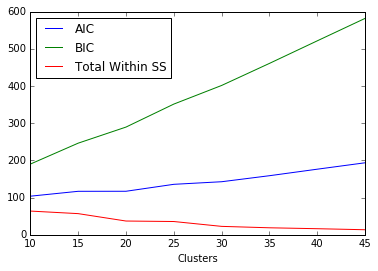

In [20]:
agencia_k_range = range(10, 50, 5)
tic()
cluster_and_plot('Agencia_ID', agencia_k_range)
tac()

It Looks Like Clusters = 20 is a good choice

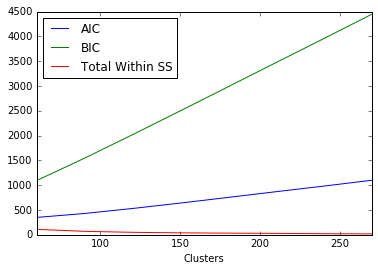

In [21]:
ruta_k_range = range(60, 300, 30)
tic()
cluster_and_plot('Ruta_SAK', ruta_k_range)
tac()

It Looks Like Clusters = 80 is a good choice

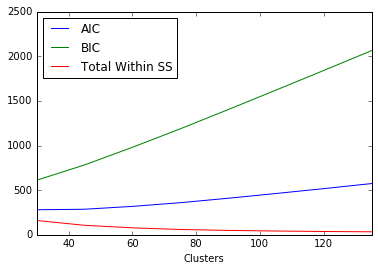

In [22]:
producto_k_range = range(30, 150, 15)
tic()
cluster_and_plot('Producto_ID', producto_k_range)
tac()

It Looks Like Clusters = 45 is a good choice







Time passed: 0.0hour:3.0min:5.0sec


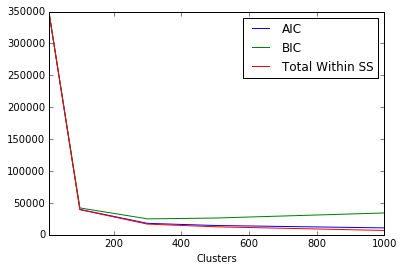

In [24]:
tic()
cliente_k_range = [10,100,300,500,1000]
cluster_and_plot('Cliente_ID', cliente_k_range)
tac()

It looks like 300 or 400 would work

### Now we the right amount of centroids, we process the clustering and fitting

In [36]:
# --- HYPERPARAMETERS FOR FEATURE EXTRACTION ---

# number of clusters to group depot/route/produc (if 0 will not be added as feature)
num_clusters_agencia = 20
num_clusters_ruta = 80
num_clusters_producto = 45
num_clusters_cliente = 400

In [37]:
def cluster_and_save(feat_name, num_clusters):
    '''
    Input: 
        - idx: the index of the feature we want to cluster, one-hot-encode, and add to our features
        - num_clusters: the number of clusters we want to use to group the feature values
    '''   
    global data

    # run clustering by demand using info from week 3-9
    feat = data.loc[:, feat_name]
    tar = data.loc[:, 'pairs_mean']
    feat_tar = pd.concat([feat, tar], axis=1)
        
    # group by feature
    grouped_ft = feat_tar.groupby(feat_name)
    grouped_ft = pd.merge(grouped_ft.median().reset_index(), grouped_ft.std().reset_index(), how='left', on=[feat_name])
    
    demand_info_unique = grouped_ft.iloc[:,1:]
    demand_info_unique[pd.isnull(demand_info_unique)] = 0
    
    # we use the kmeans clustering algorithm
    h2odf = h2o.H2OFrame(demand_info_unique)
    kmeans = H2OKMeansEstimator(k=num_clusters, init="Random", seed=2, standardize=True)

    kmeans.train(x = h2odf.col_names, training_frame = h2odf)
    clusters_h2odf = kmeans.predict(h2odf)
    clustersdf = clusters_h2odf.as_data_frame(True)
    clusters = clustersdf.predict.get_values()
    
    # plot demand/cluster
    plt.figure(figsize=(15, 3))
    for c in range(num_clusters):
        d_median = demand_info_unique.iloc[clusters==c,0]
        d_std = demand_info_unique.iloc[clusters==c,1]
        plt.plot(d_median,d_std,'.')
        plt.xlabel('median')
        plt.ylabel('std')
    plt.savefig(path_datadrive+'h2o-clustByDem_{}_{}'.format(feat_name, num_clusters))
    
    # create new dataframe to save the mapping from feature ID to cluster ID
    feat_clust_map = pd.DataFrame(data = grouped_ft.iloc[:,0], columns=[feat_name])
    feat_clust_map.insert(1, feat_name+'_clust_ID', clusters)

    # save the new feature
    feat_clust_map.to_csv(path_datadrive+"h2o-clustByDem_{}_{}.csv".format(feat_name, num_clusters), index=False)

('agencia...', 20)



Time passed: 0.0hour:0.0min:6.0sec


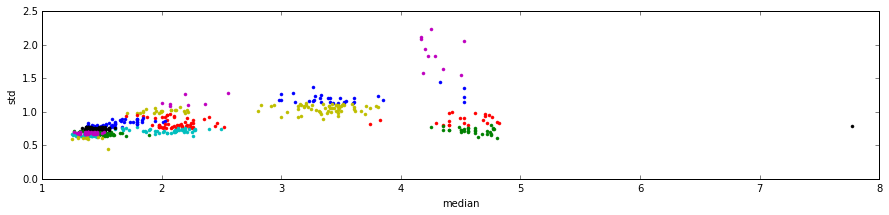

In [38]:
tic()
print("agencia...", num_clusters_agencia)
cluster_and_save('Agencia_ID', num_clusters_agencia)
tac()

('ruta... ', 20)



Time passed: 0.0hour:0.0min:6.0sec


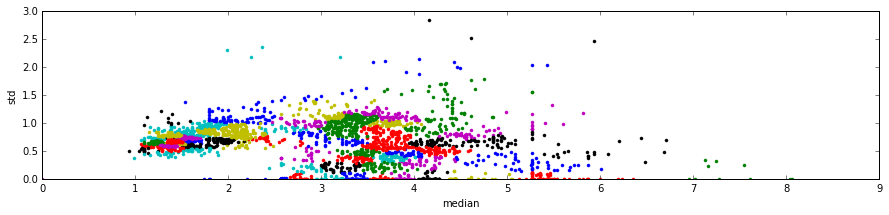

In [39]:
tic()
print("ruta... ", num_clusters_ruta)
cluster_and_save('Ruta_SAK', num_clusters_ruta)
tac()

('prod...', 20)



Time passed: 0.0hour:0.0min:7.0sec


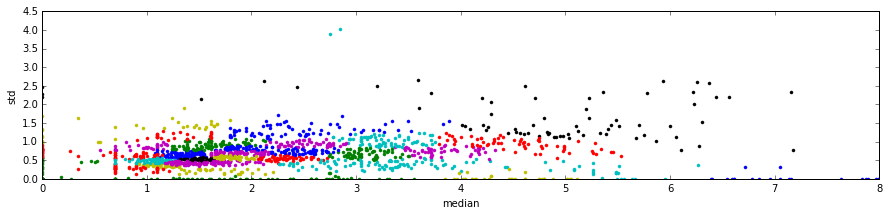

In [40]:
tic()
print("prod...", num_clusters_producto)
cluster_and_save('Producto_ID', num_clusters_producto)
tac()

('Client...', 20)



Time passed: 0.0hour:1.0min:28.0sec


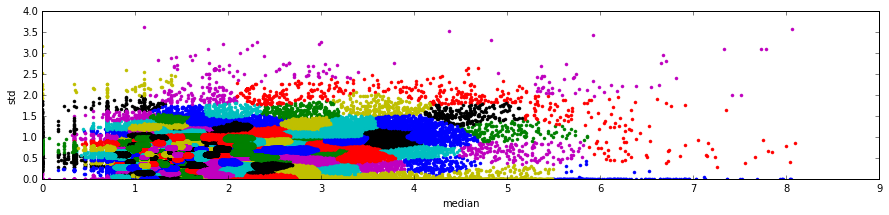

In [41]:
tic()
print("Client...", num_clusters_cliente)
cluster_and_save('Cliente_ID', num_clusters_cliente)
tac()